In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import jieba

# load data

In [2]:
with open("./data/data_input.pkl", "rb") as f:
    text_train, label_train, text_test, label_test, label_names = pickle.load(f)

# 分词

In [3]:
def text_to_tokens(text, stop_words = []):
    """
    text: 需要分词的文本
    stop_words: 停用词表，如果有的话
    """
    words = jieba.cut(text)
    tokens = [word for word in words if word not in stop_words]
    return tokens

In [4]:
train_tokens = np.array([text_to_tokens(text) for text in text_train])
test_tokens = np.array([text_to_tokens(text) for text in text_test])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "/home/mengzhen/python3-tf-gpu/lib/python3.6/site-packages/jieba/__init__.py", line 152, in initialize
    _replace_file(fpath, cache_file)
PermissionError: [Errno 1] Operation not permitted: '/tmp/tmp4l_2yqbe' -> '/tmp/jieba.cache'
Loading model cost 2.368 seconds.
Prefix dict has been built succesfully.


In [6]:
print("train size: ", train_tokens.shape)
print("test size: ", test_tokens.shape)

train size:  (5734,)
test size:  (3656,)


# fasttext 表征文本

In [15]:
import fasttext

# model path 
PROJECT_HOME = "/usr/lib/carter/carter-predictor/"
PRETRAINED_MODEL_PATH = PROJECT_HOME + "pretrained_models/"
FT_MODEL_NAME = 'event_corpus_20181112_fasttext_vec300_epoch50.bin'

# load fasttext model
ft_model = fasttext.load_model(PRETRAINED_MODEL_PATH + FT_MODEL_NAME)
embedding_dim = len(ft_model["上海"])

In [21]:
print("embedding dim:", embedding_dim)

embedding dim: 300


In [25]:
# 词向量均值作为特征
def get_fasttext_avg(tokens_list, model):
    cnt = 0
    embedding = np.zeros(embedding_dim)
    for token in tokens_list:
        if token in model.words:
            embedding += model[token]
            cnt += 1
    return embedding/cnt

In [26]:
X_train = np.array([get_fasttext_avg(tokens, ft_model) for tokens in train_tokens])
X_test = np.array([get_fasttext_avg(tokens, ft_model) for tokens in test_tokens])

In [27]:
print("data train shape: ", X_train.shape)
print("data test shape: ", X_test.shape)

data train shape:  (5734, 300)
data test shape:  (3656, 300)


# 训练分类模型

In [41]:
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.utils import to_categorical
import tensorflow as tf
from keras.optimizers import Adam


In [38]:
# 使用gpu
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# 设置定量的GPU使用量
config = tf.ConfigProto()
session = tf.Session(config=config)

# 设置最少显存
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [36]:
Y_train = to_categorical(label_train)
Y_test = to_categorical(label_test)

In [115]:
input_layer = Input(shape=(embedding_dim,), dtype=float)
dense_layer = Dense(units=64)(input_layer)
dropout_layer = Dropout(rate=0.2)(dense_layer)
output_layer = Dense(units=len(label_names), activation="softmax")(dropout_layer)

model = Model(input_layer, output_layer)

In [116]:
optimizer=Adam(lr=0.01)
model.compile(optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

In [117]:
history = model.fit(x=X_train, y=Y_train, batch_size=32, epochs=20, validation_split=0.1)

Train on 5160 samples, validate on 574 samples
Epoch 1/20
5160/5160 [==============================] - 2s 415us/step - loss: 2.0037 - acc: 0.4424 - val_loss: 1.5132 - val_acc: 0.5314
Epoch 2/20
5160/5160 [==============================] - 1s 141us/step - loss: 1.5007 - acc: 0.5523 - val_loss: 1.4188 - val_acc: 0.5540
Epoch 3/20
5160/5160 [==============================] - 1s 119us/step - loss: 1.4370 - acc: 0.5556 - val_loss: 1.3968 - val_acc: 0.5784
Epoch 4/20
5160/5160 [==============================] - 1s 150us/step - loss: 1.3633 - acc: 0.5824 - val_loss: 1.3638 - val_acc: 0.5836
Epoch 5/20
5160/5160 [==============================] - 1s 169us/step - loss: 1.3000 - acc: 0.5903 - val_loss: 1.4058 - val_acc: 0.5592
Epoch 6/20
5160/5160 [==============================] - 1s 142us/step - loss: 1.2634 - acc: 0.6037 - val_loss: 1.3602 - val_acc: 0.5923
Epoch 7/20
5160/5160 [==============================] - 1s 133us/step - loss: 1.2378 - acc: 0.6110 - val_loss: 1.3955 - val_acc: 0.5889
E

In [118]:
# 训练过程
import matplotlib.pyplot as plt
def plot_accuracy(history):
    fig = plt.figure()
#     plt.subplot(121)
    plt.plot(history.history['acc'],label='training acc')
    plt.plot(history.history['val_acc'],label='val acc')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='lower right')
    plt.show()
    
def plot_loss(history):
#     plt.subplot(121)
    fig = plt.figure()
    plt.plot(history.history['loss'],label='training loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.show()


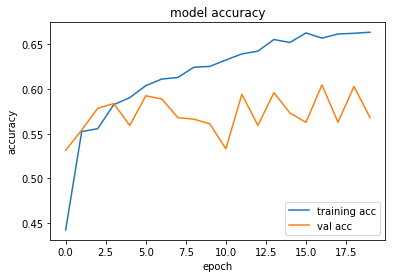

In [119]:
plot_accuracy(history)

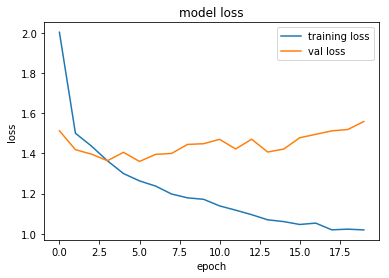

In [120]:
plot_loss(history)

# test

In [105]:
# predict probability
test_prob = model.predict(X_test)

In [106]:
test_pred = [np.argmax(prob) for prob in test_prob]

# evaluation

In [107]:
from sklearn.metrics import classification_report
print(classification_report(y_pred= test_pred, y_true=label_test))

              precision    recall  f1-score   support

           0       0.53      0.83      0.65       254
           1       0.68      0.66      0.67       374
           2       0.39      0.45      0.42       310
           3       0.39      0.37      0.38       280
           4       0.51      0.79      0.62       276
           5       0.57      0.79      0.66       175
           6       0.62      0.62      0.62       159
           7       0.38      0.55      0.45       190
           8       0.28      0.06      0.10       164
           9       0.30      0.06      0.10       113
          10       0.74      0.81      0.77       145
          11       0.53      0.55      0.54        47
          12       0.18      0.39      0.24        28
          13       0.62      0.73      0.67        83
          14       0.41      0.12      0.18        60
          15       0.33      0.04      0.07        24
          16       0.70      0.61      0.65        85
          17       0.37    